In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/financial-risk/financial_risk_assessment.csv


In [2]:
df = pd.read_csv("/kaggle/input/financial-risk/financial_risk_assessment.csv")
print(df.head(3))
print("The dataset has {} observations and {} variables".format(df.shape[0], df.shape[1]))
print("Information about the data", df.info())

   Age      Gender Education Level Marital Status   Income  Credit Score  \
0   49        Male             PhD       Divorced  72799.0         688.0   
1   57      Female      Bachelor's        Widowed      NaN         690.0   
2   21  Non-binary        Master's         Single  55687.0         600.0   

   Loan Amount Loan Purpose Employment Status  Years at Current Job  \
0      45713.0     Business        Unemployed                    19   
1      33835.0         Auto          Employed                     6   
2      36623.0         Home          Employed                     8   

  Payment History  Debt-to-Income Ratio  Assets Value  Number of Dependents  \
0            Poor              0.154313      120228.0                   0.0   
1            Fair              0.148920       55849.0                   0.0   
2            Fair              0.362398      180700.0                   3.0   

              City State       Country  Previous Defaults  \
0   Port Elizabeth    AS        

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


# Data Cleaning

## Handling Missing Values

In [3]:
# Identifying Missing values: overview
df.isnull().sum().sum()  # total missing values in the dataset
print("\nMissing values (count):\n", df.isnull().sum())# number missing values in each variable

# Rank variables with the highest percentage of missing data first
df_missing = df.isnull().sum().sort_values(ascending=False) / len(df) * 100
print("\nRanking Missing values (%):\n", df_missing)


Missing values (count):
 Age                         0
Gender                      0
Education Level             0
Marital Status              0
Income                   2250
Credit Score             2250
Loan Amount              2250
Loan Purpose                0
Employment Status           0
Years at Current Job        0
Payment History             0
Debt-to-Income Ratio        0
Assets Value             2250
Number of Dependents     2250
City                        0
State                       0
Country                     0
Previous Defaults        2250
Marital Status Change       0
Risk Rating                 0
dtype: int64

Ranking Missing values (%):
 Assets Value             15.0
Previous Defaults        15.0
Income                   15.0
Credit Score             15.0
Loan Amount              15.0
Number of Dependents     15.0
Age                       0.0
Marital Status Change     0.0
Country                   0.0
State                     0.0
City                      0.0
P

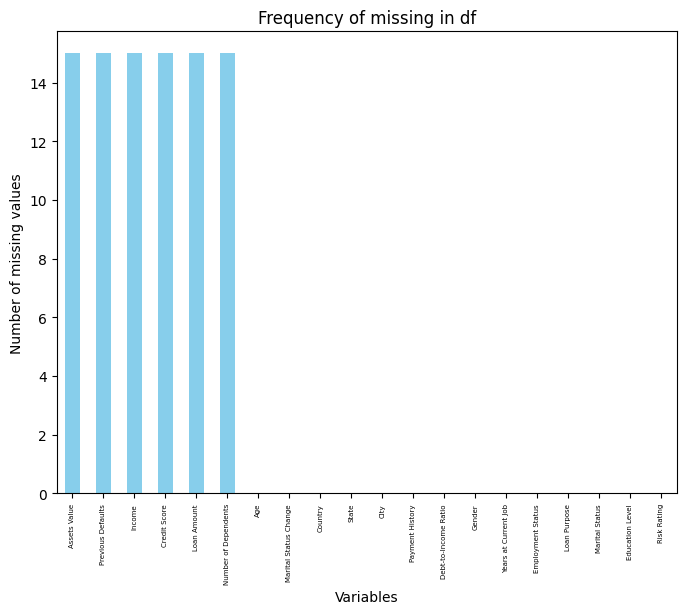

<Axes: >

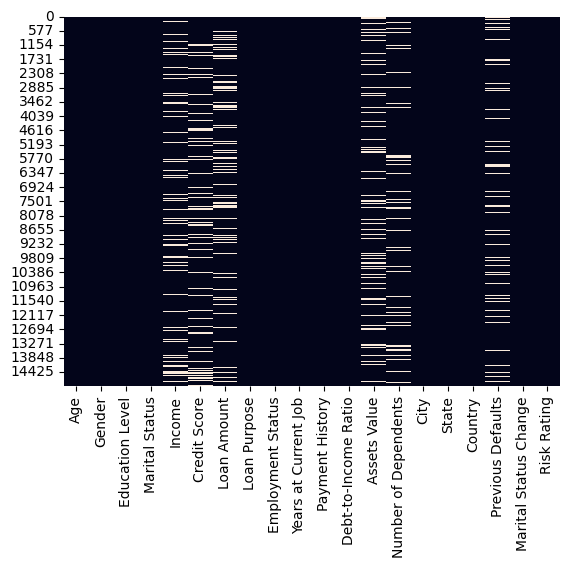

In [4]:

## Identifying Missing values: Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Bar plot
plt.figure(figsize=(8, 6))
df_missing.plot(kind='bar', color='skyblue')
plt.title('Frequency of missing in df')
plt.xlabel('Variables')
plt.ylabel('Number of missing values')
plt.xticks(rotation=90, size=5)
plt.show()

# Using seaborn package
sns.heatmap(df.isnull(), cbar=False)

In [5]:
## Determine the type of missing values : Using Logistics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder

df_encoded = df.copy()
for col in df_encoded.select_dtypes(include='object').columns:
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col].astype(str))
Var_MV = ['Income','Credit Score','Loan Amount','Assets Value','Number of Dependents','Previous Defaults']

for col in Var_MV:
    df_encoded['missing_flag'] = df_encoded[col].isnull().astype(int)

# Predict missingness from other features
    X = df_encoded.drop(columns=[col, 'missing_flag']).fillna(df_encoded.mean())
    y = df_encoded['missing_flag']

    model = LogisticRegression(max_iter=500)
    auc = cross_val_score(model, X, y, cv=5, scoring='roc_auc').mean()
    if auc >= 0.6:
        print(f"AUC score for predicting missingness in {col}: {auc:.3f}. "
              f" Therefore, since the AUC score is not significant (auc >= 0.6), the missingness in {col} is not MCAR.")
    else:
        print(f"AUC score for predicting missingness in {col}: {auc:.3f}, "
              f" Therefore, since the AUC score is significant (auc approx. 0.5), the missingness in {col} is due to MCAR.")

AUC score for predicting missingness in Income: 0.493,  Therefore, since the AUC score is significant (auc approx. 0.5), the missingness in Income is due to MCAR.
AUC score for predicting missingness in Credit Score: 0.503,  Therefore, since the AUC score is significant (auc approx. 0.5), the missingness in Credit Score is due to MCAR.
AUC score for predicting missingness in Loan Amount: 0.500,  Therefore, since the AUC score is significant (auc approx. 0.5), the missingness in Loan Amount is due to MCAR.
AUC score for predicting missingness in Assets Value: 0.508,  Therefore, since the AUC score is significant (auc approx. 0.5), the missingness in Assets Value is due to MCAR.
AUC score for predicting missingness in Number of Dependents: 0.499,  Therefore, since the AUC score is significant (auc approx. 0.5), the missingness in Number of Dependents is due to MCAR.
AUC score for predicting missingness in Previous Defaults: 0.507,  Therefore, since the AUC score is significant (auc appro